This notebook implements some ideas provided by Jaron Thompson during helpful discussions on 8-01-24.

# Header Material

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy.stats as ss

from sklearn.gaussian_process import GaussianProcessRegressor,kernels
from sklearn.model_selection import train_test_split, KFold,LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error,mean_squared_error

In [3]:
from src.models.constants import Constants
from src.models import util
from src.models.gaussian_process import featurize

In [4]:
plt.style.use('seaborn-v0_8-talk')
cmap = plt.get_cmap("tab10")
raw_dir = "C:/Users/Hermans_Desktop1/OneDrive - UW-Madison/Documents/Research/2022-P4 (Pt DH ML)/iterative_catalyst_design/data/raw"
processed_dir = "C:/Users/Hermans_Desktop1/OneDrive - UW-Madison/Documents/Research/2022-P4 (Pt DH ML)/iterative_catalyst_design/data/processed"
n_map = {1:"Base",2:"Thru Rnd 1",3:"Thru Rnd 2",4:"Thru Rnd 3",5:"Thru Rnd 4",6:"Thru Rnd 5",7:"Thru Rnd 6-GP"}
seed=0
fname = f'3-averaged_Round5-Standardized.csv' #Data through Round 4 w. GP
f = processed_dir+"/"+fname
df = pd.read_csv(f,index_col=0)
df.head()

,Pt,Sn,Ga,Fe,Cu,Ca,Mn,Zn,k_d,Y0,lifetime_yield,Y_pc,sqrtY0Y_pc,lifetime_yield_sd,Y_pc_sd,sqrtY0Y_pc_sd
0,1,0,0,0,0,0,0,0,0.009888,0.079167,7.906378,7.122892,0.749430,1.391523,0.117528,0.012366
1,1,0,0,0,0,1,0,0,0.006639,0.052747,7.944507,6.330042,0.577835,1.398233,0.104446,0.009534
2,1,0,0,0,0,4,0,0,0.005610,0.211910,37.771519,27.945063,2.433485,6.647787,0.461094,0.040152
3,1,0,0,0,0,8,0,0,0.006555,0.162041,24.720653,19.593907,1.781855,4.350835,0.323299,0.029401
4,1,0,0,0,1,0,0,0,0.006305,0.211454,33.538397,26.152810,2.351620,5.902758,0.431521,0.038802


# Training Data $r^2$ vs. leave-one-out CV $r^2$.

This section calculates $r^2$ on the training data (i.e. model $r^2$) and compares this to $r^2$ from LOO-CV. This estimates overfitting.

In [5]:
X,y=util.get_Xy(df)
n = X.shape[0]
X = X.to_numpy()
y = y.to_numpy()
y_preds = []
y_stds = []
y_actuals = []
loo = KFold(n_splits=n)
for train_index,test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    pipeline = make_pipeline(GaussianProcessRegressor(kernel=1*kernels.RBF(length_scale=1.0,length_scale_bounds=(1e-2,1e2)),n_restarts_optimizer=5,random_state=seed))
    pipeline.fit(X_train,y_train)
    y_pred,y_pred_std = pipeline.predict(X_test,return_std=True)
    y_preds.append(y_pred[0])
    y_stds.append(y_pred_std[0])
    y_actuals.append(y_test[0])

pred = np.asarray(y_preds)
expt = np.asarray(y_actuals)    
mae = np.mean(np.abs(pred-expt))
slope, intercept, r_value, p_value, std_err = ss.linregress(expt,pred)
r2 = r_value**2
rmse = np.sqrt(mean_squared_error(expt,pred))
mae_norm = np.mean(np.abs(pred-expt)/expt)
rmse_norm = rmse / np.mean(expt)
label=f'Round {4} GP Norm_MAE {mae_norm:.3} Norm_RMSE {rmse_norm:.3} R2: {r2:.3}'

X,y=util.get_Xy(df)
X = X.to_numpy()
y = y.to_numpy()
pipeline = make_pipeline(GaussianProcessRegressor(kernel=1*kernels.RBF(length_scale=1.0,length_scale_bounds=(1e-2,1e2)),n_restarts_optimizer=5,random_state=seed))
pipeline.fit(X,y)
r2_train=pipeline.score(X,y)
print(f'r2 of LOO-CV: {r2:.3} r2 of Training Data: {r2_train:.3}')

r2 of LOO-CV: 0.494 r2 of Training Data: 1.0


*Clearly, our data is overfitting. We need to introduce noise estimates to mitigate this.*

# Adding a universal uncertainty. 
In this section we try modeling the gaussian process with noise from that of Pt1Sn4Ca4, which has the most replicates. To start, we only include uncertainty due to reactor (i.e. not batch-to-batch synthesis uncertainty).

4.84 +/- 0.119. Count: 11


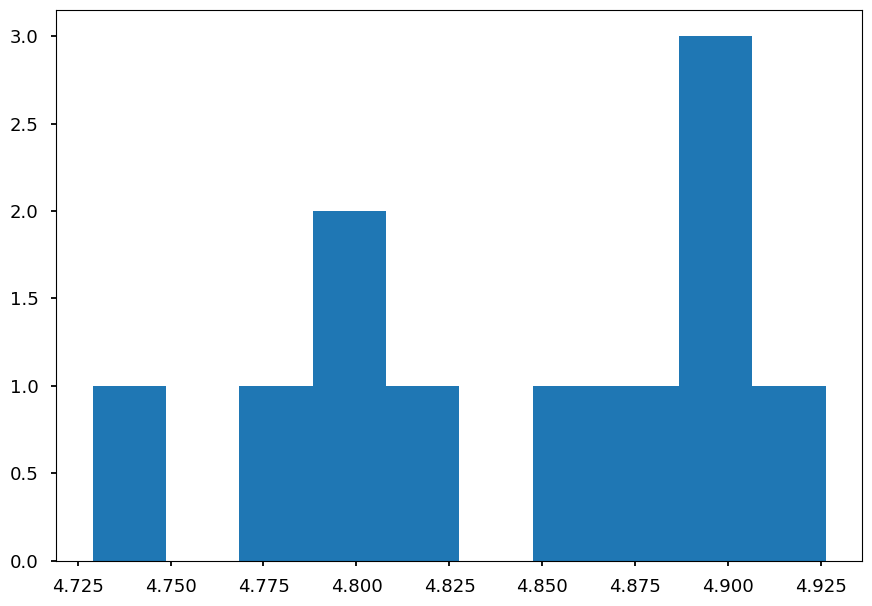

Scipy Stats Normal Test: NormaltestResult(statistic=0.8057082124443042, pvalue=0.6684096090133678)
Shapiro-Wilks: ShapiroResult(statistic=0.9312961335523187, pvalue=0.4241139042569061)
Var: 0.00353


C:\Users\Hermans_Desktop1\Anaconda3\envs\py312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  res = hypotest_fun_out(*samples, **kwds)


In [38]:
#estimating noise level
df_noise = pd.read_csv(processed_dir+"/"+"2-cleanedup_All Data Through Round 6 and Addl Trials.csv")
df_noise = df_noise.loc[(df_noise['Sn']==4) & (df_noise['Ga']==0) & (df_noise['Fe']==0) & (df_noise['Cu']==0) & (df_noise['Ca']==4)]
df_noise=df_noise.loc[~df_noise['Catalyst'].isin(['Pt1Sn4Ca4 (#3)','Pt1Sn4Ca4 (#2)','Pt1Sn4Ca4 (HD)'])] #only first batch
scores=df_noise['sqrtY0Y_pc'].to_numpy()
print(f'{np.mean(scores):.3} +/- {2*np.std(scores):.3}. Count: {scores.shape[0]}')
plt.hist(scores)
plt.show()
print(f'Scipy Stats Normal Test: {ss.normaltest(scores)}')
print(f'Shapiro-Wilks: {ss.shapiro(scores)}') # https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/
print(f'Var: {np.var(scores):.3}')
chosen_var = np.var(scores)

In [43]:
X,y=util.get_Xy(df)
X = X.to_numpy()
y = y.to_numpy()
pipeline = make_pipeline(GaussianProcessRegressor(alpha=np.array([chosen_var for i in range(X.shape[0])]),
                                                  kernel=1*kernels.RBF(length_scale=1.0,length_scale_bounds=(1e-2,1e2)),n_restarts_optimizer=5,random_state=seed))
pipeline.fit(X,y)
r2_train_error=pipeline.score(X,y)
print(r2_train_error)

0.9999680755530708


The new r2 is still pretty high. It looks like the uncertainty in this area is not representative of the general uncertainty. Let's use the largest error bars calculated from the replicate experiments

In [44]:
new_var = 0.14
X,y=util.get_Xy(df)
X = X.to_numpy()
y = y.to_numpy()
pipeline = make_pipeline(GaussianProcessRegressor(alpha=np.array([new_var for i in range(X.shape[0])]),
                                                  kernel=1*kernels.RBF(length_scale=1.0,length_scale_bounds=(1e-2,1e2)),n_restarts_optimizer=5,random_state=seed))
pipeline.fit(X,y)
r2_train_error=pipeline.score(X,y)
print(r2_train_error)

0.9631345520903216


This r2 is better but still too high. Let's include larger uncertainty: 2*STDEV in largest tube uncertainty.

In [45]:
new_var = 0.75
X,y=util.get_Xy(df)
X = X.to_numpy()
y = y.to_numpy()
pipeline = make_pipeline(GaussianProcessRegressor(alpha=np.array([new_var for i in range(X.shape[0])]),
                                                  kernel=1*kernels.RBF(length_scale=1.0,length_scale_bounds=(1e-2,1e2)),n_restarts_optimizer=5,random_state=seed))
pipeline.fit(X,y)
r2_train_error=pipeline.score(X,y)
print(r2_train_error)

0.6849272606479562


This is much closer to the error in our LOO-CV. Let's look at parity plots with and without this error.

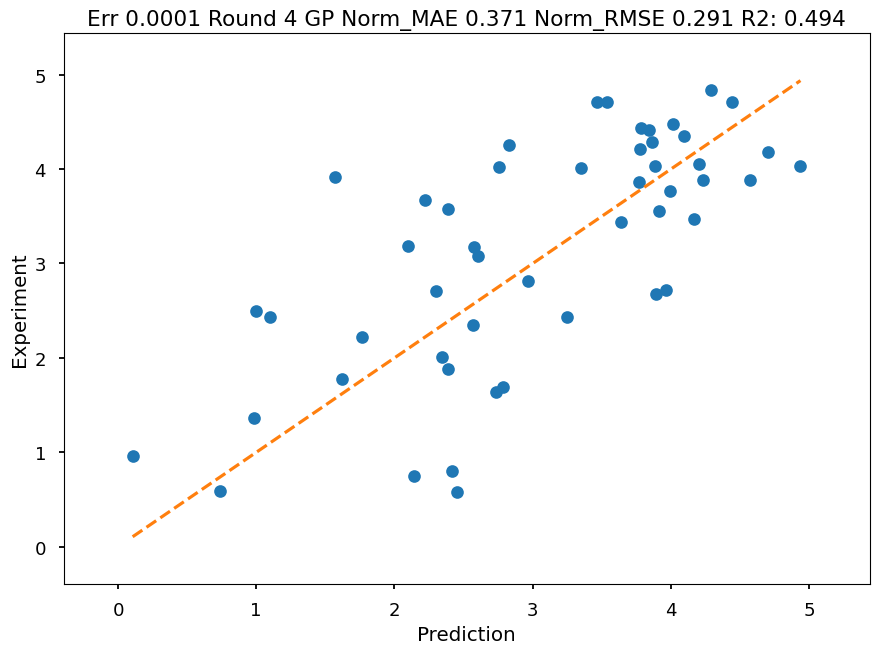

[0.00999879 0.00999893 0.00999968 0.0099999  0.00999863 0.0099997
 0.00999981 0.00999946 0.00999955 0.00999899 0.00999945 0.00999985
 0.00999985 0.00999986 0.0099999  0.00999744 0.00999984 0.00999988
 0.00999986 0.00999989 0.00999991 0.00999738 0.00999865 0.00999877
 0.00999855 0.00999928 0.00999944 0.00999875 0.00999898 0.00999893
 0.00999525 0.00999873 0.00999913 0.00999964 0.00999926 0.00999853
 0.00999883 0.00999935 0.00999933 0.00999859 0.00999896 0.00999866
 0.00999872 0.00999977 0.00999913 0.0099998  0.00999983 0.00999981
 0.00999985 0.00999984]
r2 of LOO-CV: 0.494 r2 of Training Data: 1.0


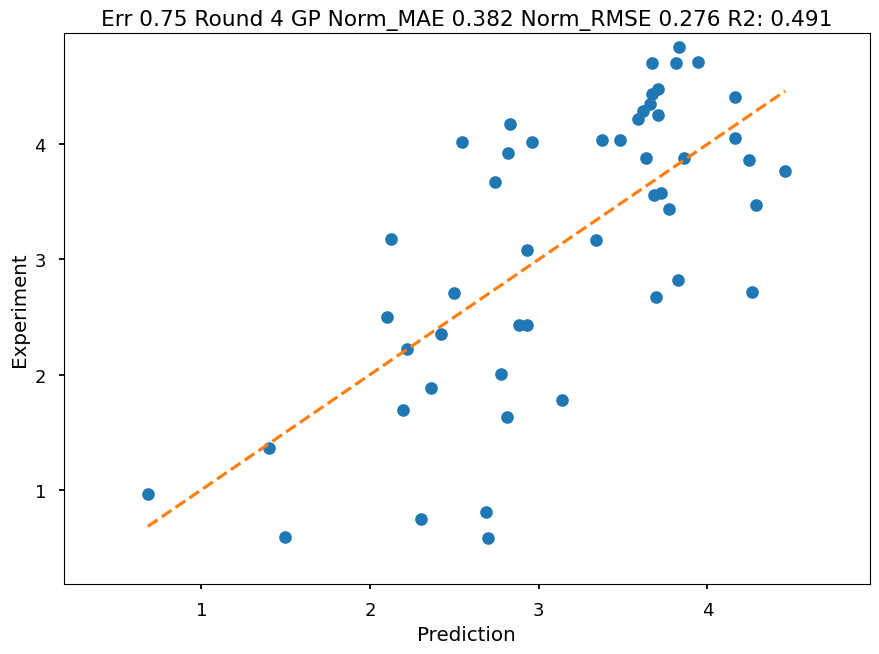

[0.39411094 0.31744394 0.40326432 0.56788708 0.31505097 0.39838552
 0.36841774 0.46327897 0.4352889  0.32069973 0.48056407 0.4358133
 0.44316194 0.44826981 0.59677823 0.31255893 0.42863794 0.45457996
 0.44918317 0.46644349 0.59571952 0.30831002 0.29987025 0.29275781
 0.40237939 0.37704608 0.46683278 0.31055521 0.33791474 0.33147428
 0.29514744 0.32504886 0.33618551 0.39260142 0.33895712 0.27477925
 0.32575638 0.37143113 0.34966836 0.28555856 0.32766041 0.29132717
 0.29585867 0.40371324 0.33725107 0.453311   0.41924949 0.46891909
 0.5179768  0.49403845]
r2 of LOO-CV: 0.491 r2 of Training Data: 0.685


In [9]:
for err in [0.0001,0.75]:
    X,y=util.get_Xy(df)
    n = X.shape[0]
    X = X.to_numpy()
    y = y.to_numpy()
    y_preds = []
    y_stds = []
    y_actuals = []
    loo = KFold(n_splits=n)
    for train_index,test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        pipeline = make_pipeline(GaussianProcessRegressor(alpha=np.array([err for i in range(X_train.shape[0])]),
                                                          kernel=1*kernels.RBF(length_scale=1.0,length_scale_bounds=(1e-2,1e2)),n_restarts_optimizer=5,random_state=seed))
        pipeline.fit(X_train,y_train)
        y_pred,y_pred_std = pipeline.predict(X_test,return_std=True)
        y_preds.append(y_pred[0])
        y_stds.append(y_pred_std[0])
        y_actuals.append(y_test[0])
    
    pred = np.asarray(y_preds)
    expt = np.asarray(y_actuals)

    
    
    mae = np.mean(np.abs(pred-expt))
    slope, intercept, r_value, p_value, std_err = ss.linregress(expt,pred)
    r2 = r_value**2
    rmse = np.sqrt(mean_squared_error(expt,pred))
    mae_norm = np.mean(np.abs(pred-expt)/expt)
    rmse_norm = rmse / np.mean(expt)
    label=f'Err {err} Round {4} GP Norm_MAE {mae_norm:.3} Norm_RMSE {rmse_norm:.3} R2: {r2:.3}'
    
    
    plt.plot(pred, expt, 'o')
    # plt.plot(y_preds,y_actuals,'o')
    plt.plot([min(pred),max(pred)],[min(pred),max(pred)],'--')
    plt.xlabel("Prediction")
    plt.ylabel("Experiment")
    plt.xlim((min(pred)-.5,max(pred)+.5))
    plt.ylim((min(pred)-.5,max(pred)+.5))
    plt.title(label)
    plt.show()
    
    X,y=util.get_Xy(df)
    X = X.to_numpy()
    y = y.to_numpy()
    pipeline = make_pipeline(GaussianProcessRegressor(alpha=np.array([err for i in range(X.shape[0])]),
                                                      kernel=1*kernels.RBF(length_scale=1.0,length_scale_bounds=(1e-2,1e2)),n_restarts_optimizer=5,random_state=seed))
    pipeline.fit(X,y)
    r2_train=pipeline.score(X,y)
    means,sds = pipeline.predict(X,return_std=True)
    print(sds)
    print(f'r2 of LOO-CV: {r2:.3} r2 of Training Data: {r2_train:.3}')

# Playing around with White Kernel
Universal uncertainty using averaged data points leaves data on the table. Instead, let's use a white kernel to estimate noise (see: https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy.html#sphx-glr-auto-examples-gaussian-process-plot-gpr-noisy-py for a good example). To do this, we will include tube that a catalyst was tested in as a variable.

In [47]:
df2 = pd.read_csv(processed_dir+"/"+"2-cleanedup_All Data Through Round 6 and Addl Trials.csv")
df2.head()

,Unnamed: 0,Catalyst,Reaction,Tube,Date,Mass Catalyst,Mass Diluent,k_d,Y0,lifetime_yield,Y_pc,sqrtY0Y_pc,Pt,Sn,Ga,Fe,Cu,Ca,Mn,Zn
0,0,Pt1/γ-Al2O3 2/5/24,24-005,1,2024-02-05,20.0,120.2,0.011951,0.093141,7.793377,7.350753,0.827439,1,0.0,0.0,0.0,0.0,0.0,0,0
1,1,Pt1/γ-Al2O3 2/5/24,24-005,2,2024-02-05,20.1,120.0,0.011695,0.138308,11.826379,11.112063,1.239711,1,0.0,0.0,0.0,0.0,0.0,0,0
2,2,Pt1/γ-Al2O3 2/5/24,24-005,3,2024-02-05,20.0,120.0,0.010522,0.063163,6.002886,5.522449,0.590604,1,0.0,0.0,0.0,0.0,0.0,0,0
3,3,Pt1/γ-Al2O3 2/5/24,24-005,4,2024-02-05,20.0,120.0,0.009353,0.055320,5.915015,5.288208,0.540875,1,0.0,0.0,0.0,0.0,0.0,0,0
4,4,Pt1/γ-Al2O3 2/5/24,24-005,5,2024-02-05,20.1,120.2,0.009263,0.062064,6.700162,5.974731,0.608945,1,0.0,0.0,0.0,0.0,0.0,0,0


In [39]:
def remove_duplicates(X_train,X_test,y_train,y_test):
    idx_to_remove = []
    for i in range(X_test.shape[0]): #for each test datapoint:
        for j in range(X_train.shape[0]):
            if np.array_equal(X_test[i,:],X_train[j,:]):
                print("Found equal")
                print(X_test[i,:])
                print(X_train[j,:])
                idx_to_remove.append(j)
    return np.delete(X_train,idx_to_remove,axis=0),np.delete(y_train,idx_to_remove,axis=0)

Found equal
[6. 0. 0. 0. 0. 0. 1. 1.]
[6. 0. 0. 0. 0. 0. 1. 1.]
Found equal
[1. 4. 0. 0. 0. 4. 3. 9.]
[1. 4. 0. 0. 0. 4. 3. 9.]
Found equal
[1. 4. 0. 0. 0. 4. 3. 9.]
[1. 4. 0. 0. 0. 4. 3. 9.]
Found equal
[1. 4. 0. 0. 0. 4. 3. 9.]
[1. 4. 0. 0. 0. 4. 3. 9.]
Found equal
[1. 4. 0. 0. 0. 4. 3. 9.]
[1. 4. 0. 0. 0. 4. 3. 9.]
Found equal
[2. 4. 0. 0. 0. 4. 3. 9.]
[2. 4. 0. 0. 0. 4. 3. 9.]
Found equal
[3. 4. 0. 0. 0. 4. 3. 9.]
[3. 4. 0. 0. 0. 4. 3. 9.]
Found equal
[3. 4. 0. 0. 0. 4. 3. 9.]
[3. 4. 0. 0. 0. 4. 3. 9.]
Found equal
[4. 4. 0. 0. 0. 4. 3. 9.]
[4. 4. 0. 0. 0. 4. 3. 9.]
Found equal
[5. 4. 0. 0. 0. 4. 3. 9.]
[5. 4. 0. 0. 0. 4. 3. 9.]
Found equal
[6. 4. 0. 0. 0. 4. 3. 9.]
[6. 4. 0. 0. 0. 4. 3. 9.]
Found equal
[6. 4. 0. 0. 0. 4. 3. 9.]
[6. 4. 0. 0. 0. 4. 3. 9.]
Found equal
[6. 4. 0. 0. 0. 4. 3. 9.]
[6. 4. 0. 0. 0. 4. 3. 9.]
Found equal
[1. 4. 0. 0. 0. 4. 3. 9.]
[1. 4. 0. 0. 0. 4. 3. 9.]
Found equal
[1. 4. 0. 0. 0. 4. 3. 9.]
[1. 4. 0. 0. 0. 4. 3. 9.]
Found equal
[1. 4. 0. 0. 0. 4. 3. 9.]
[1

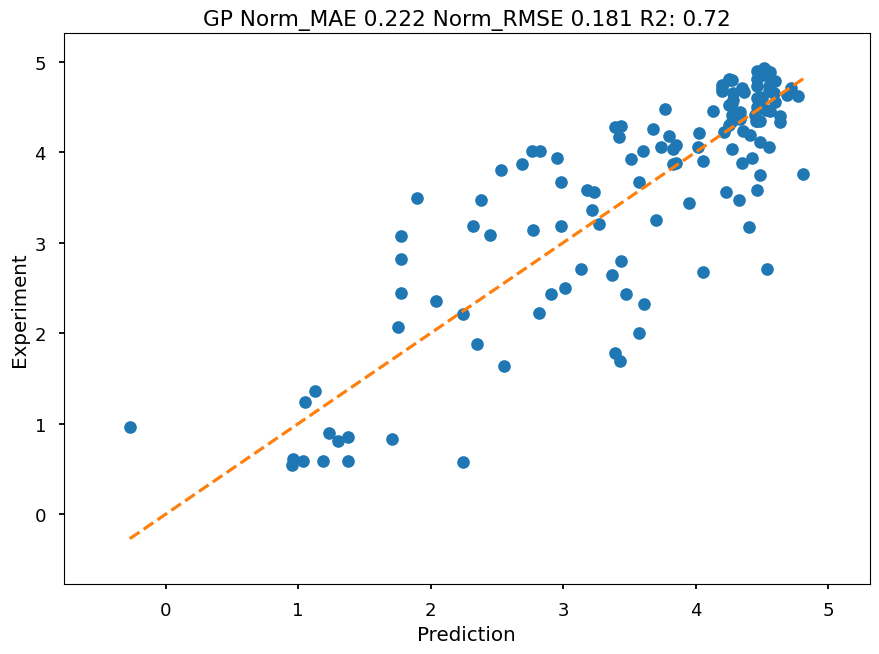

In [42]:
df2["diversity"] = df2[["Pt","Sn","Ga","Fe","Cu","Ca"]].astype(bool).sum(axis=1)
df2["loading"] = df2[["Pt","Sn","Ga","Fe","Cu","Ca"]].sum(axis=1)

X = df2[["Tube","Sn","Ga","Fe","Cu","Ca","diversity","loading"]].to_numpy()
y = df2["sqrtY0Y_pc"].to_numpy()
n = X.shape[0]
y_preds = []
y_stds = []
y_actuals = []
loo = KFold(n_splits=n)
for train_index,test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    X_train,y_train = remove_duplicates(X_train,X_test,y_train,y_test) #avoid leakage by removing identical entries
    kernel = 1*kernels.RBF(length_scale=1.0,length_scale_bounds=(1e-2,1e2))+kernels.WhiteKernel(noise_level=1, noise_level_bounds=(1e-5, 1e1))
    pipeline = make_pipeline(GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=5,random_state=seed))
    pipeline.fit(X_train,y_train)
    y_pred,y_pred_std = pipeline.predict(X_test,return_std=True)
    y_preds.append(y_pred[0])
    y_stds.append(y_pred_std[0])
    y_actuals.append(y_test[0])

pred = np.asarray(y_preds)
expt = np.asarray(y_actuals)



mae = np.mean(np.abs(pred-expt))
slope, intercept, r_value, p_value, std_err = ss.linregress(expt,pred)
r2 = r_value**2
rmse = np.sqrt(mean_squared_error(expt,pred))
mae_norm = np.mean(np.abs(pred-expt)/expt)
rmse_norm = rmse / np.mean(expt)
label=f'GP Norm_MAE {mae_norm:.3} Norm_RMSE {rmse_norm:.3} R2: {r2:.3}'


plt.plot(pred, expt, 'o')
# plt.plot(y_preds,y_actuals,'o')
plt.plot([min(pred),max(pred)],[min(pred),max(pred)],'--')
plt.xlabel("Prediction")
plt.ylabel("Experiment")
plt.xlim((min(pred)-.5,max(pred)+.5))
plt.ylim((min(pred)-.5,max(pred)+.5))
plt.title(label)
plt.savefig("./figures/inclusion-of-noise.png",dpi=600,bbox_inches='tight')

#Training Dataset r2
kernel = 1*kernels.RBF(length_scale=1.0,length_scale_bounds=(1e-2,1e2))+kernels.WhiteKernel(noise_level=1, noise_level_bounds=(1e-5, 1e1))
pipeline = make_pipeline(GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=5,random_state=seed))
pipeline.fit(X,y)
r2_train=pipeline.score(X,y)
means,sds = pipeline.predict(X,return_std=True)
print(f'r2 of LOO-CV: {r2:.3} r2 of Training Data: {r2_train:.3}')

[[2122.80274214 2122.80274214 2122.80274214 ... 9843.68136642
  9845.98108244 9847.29108988]
 [2093.43013159 2093.43013159 2093.43013159 ... 8537.8657422
  8539.60157113 8540.59021779]
 [2066.35078096 2066.35078096 2066.35078096 ... 7404.83340739
  7406.14361232 7406.88974595]
 ...
 [ 379.39736405  379.39736405  379.39736405 ...  288.29208651
   288.29209048  288.29209274]
 [ 374.00601131  374.00601131  374.00601131 ...  295.62082552
   295.62082793  295.6208293 ]
 [ 370.32644818  370.32644818  370.32644818 ...  303.1483672
   303.14836842  303.14836911]]
9847.291089877877 191.12997427580044


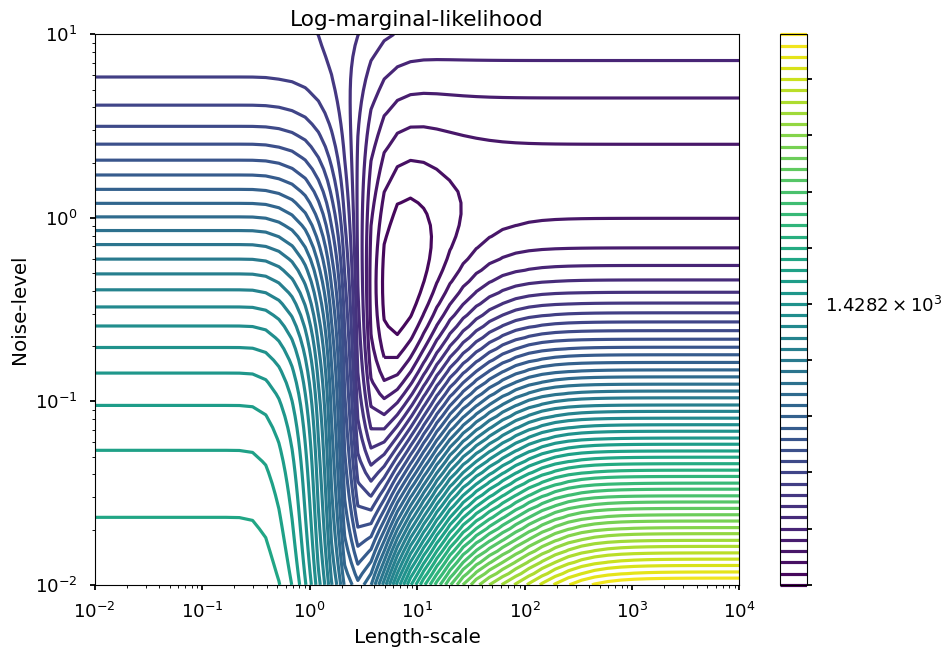

In [46]:
#hyperparameter tuning
kernel = 1.0 * kernels.RBF(length_scale=1e-1, length_scale_bounds=(1e-2, 1e3)) + kernels.WhiteKernel(
    noise_level=1e-2, noise_level_bounds=(1e-10, 1e1)
)
gpr = GaussianProcessRegressor(kernel=kernel, alpha=0.0)
gpr.fit(X,y)
from matplotlib.colors import LogNorm

length_scale = np.logspace(-2, 4, num=50)
noise_level = np.logspace(-2, 1, num=50)
length_scale_grid, noise_level_grid = np.meshgrid(length_scale, noise_level)

log_marginal_likelihood = [
    gpr.log_marginal_likelihood(theta=np.log([0.36, scale, noise]))
    for scale, noise in zip(length_scale_grid.ravel(), noise_level_grid.ravel())
]
log_marginal_likelihood = np.reshape(
    log_marginal_likelihood, newshape=noise_level_grid.shape
)
print(-log_marginal_likelihood)

vmax,vmin =  (-log_marginal_likelihood).max(),(-log_marginal_likelihood).min()
print(vmax,vmin)
level = np.around(np.logspace(np.log10(vmin), np.log10(vmax), num=50), decimals=1)
plt.contour(
    length_scale_grid,
    noise_level_grid,
    -log_marginal_likelihood,
    levels=level,
    norm=LogNorm(vmin=vmin, vmax=vmax),
)
plt.colorbar()
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Length-scale")
plt.ylabel("Noise-level")
plt.title("Log-marginal-likelihood")
plt.show()